In [29]:
from corus import load_lenta
from tqdm import tqdm
import pandas as pd

path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
# next(records)


Загрузка данных. Берем максимум 100000 примеров для ускорения обработки и обучения.


In [5]:
records = load_lenta(path)
data = []
for record in records:
    if record.topic is None:
        continue
    data.append({
        'title': record.title,
        'text': record.text,
        'topic': record.topic
    })
    if len(data) >= 200_000:
        break
df = pd.DataFrame(data)

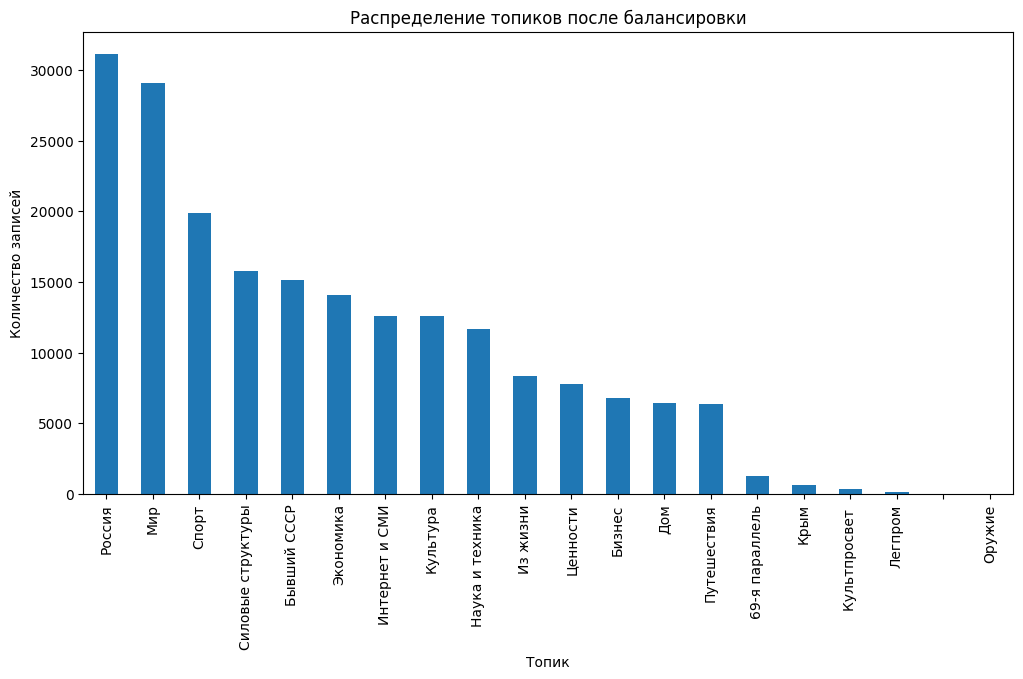

In [6]:
import matplotlib.pyplot as plt

df['topic'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Распределение топиков после балансировки')
plt.xlabel('Топик')
plt.ylabel('Количество записей')
plt.show()

In [7]:
# Фильтрация редких топиков (пример с порогом 100 образцов)
MIN_SAMPLES_PER_TOPIC = 5000
topic_counts = df['topic'].value_counts()
valid_topics = topic_counts[topic_counts >= MIN_SAMPLES_PER_TOPIC].index
df = df[df['topic'].isin(valid_topics)]


Предобработка текста. Текст из колонок title и text объединяется в одну колонку full_text, после чего каждый текст проходит через несколько этапов обработки: приведение к нижнему регистру, удаление символов, не являющихся буквами или пробелами, токенизация (разбиение на слова), удаление стоп-слов и коротких токенов. Обработанные тексты сохраняются в новой колонке processed_text. Для ускорения обработки используется библиотека swifter с прогресс-баром. Путем проб обнаружено, что лемматизация дает наилучший результат, хотя разница со стеммингом или вообще без какого-либо из двух способов минимальна.

In [8]:
import re
import nltk
import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from functools import lru_cache
import swifter

nltk.download('punkt')
nltk.download('stopwords')

morph = pymorphy2.MorphAnalyzer()
stemmer = SnowballStemmer("russian")

stop_words = set(stopwords.words('russian'))

df['full_text'] = df['title'] + ' ' + df['text']


@lru_cache(maxsize=100000)
def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

def preprocess_text(text):
    text = re.sub(r'[^а-яё\s]|\d+', '', text.lower())
    tokens = word_tokenize(text, language = "russian")
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    # tokens = [lemmatize_word(t) for t in tokens if t not in stop_words and len(t) > 2] # Лемматизация
    # tokens = [stemmer.stem(t) for t in tokens  if t not in stop_words and len(t) > 2]  # Стемминг
    return ' '.join(tokens)

df['processed_text'] = df['full_text'].swifter.progress_bar(True).apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rustam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rustam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pandas Apply:   0%|          | 0/197577 [00:00<?, ?it/s]

In [9]:
# Посчитаем частоту каждого топика
topic_counts = df['topic'].value_counts()
print(topic_counts)

topic
Россия               31122
Мир                  29057
Спорт                19892
Силовые структуры    15768
Бывший СССР          15130
Экономика            14072
Интернет и СМИ       12608
Культура             12604
Наука и техника      11636
Из жизни              8328
Ценности              7763
Бизнес                6787
Дом                   6416
Путешествия           6394
Name: count, dtype: int64


Разделяем датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используем атрибут topic.

In [10]:
from sklearn.model_selection import train_test_split

texts = df['processed_text'].apply(lambda x: x.split())
topics = df['topic']

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, topics, test_size=0.4, stratify=topics, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

Обучение Word2Vec

In [11]:
from gensim.models import Word2Vec

# Гиперпараметры:
# - vector_size=300: стандартный размер для эмбеддингов
# - window=5: контекст из 5 слов в каждую сторону
# - min_count=3: игнорировать редкие слова
# - sg=1: skip-gram (лучше для больших данных)

model_w2v = Word2Vec(
    sentences=X_train,
    vector_size=300,
    window=5,
    min_count=3,
    workers=4,
    sg=1,
    epochs=10
)

# Проверка качества эмбеддингов
print("Лишнее слово:", model_w2v.wv.doesnt_match("кошка собака мышь пицца".split()))
print("Самые похожие на 'город':", model_w2v.wv.most_similar("город", topn=5))

Лишнее слово: пицца
Самые похожие на 'город': [('ковт', 0.5183430314064026), ('тарин', 0.5182769298553467), ('тельабьяд', 0.5142472982406616), ('населенный', 0.50965815782547), ('портовый', 0.5079448819160461)]


Загрузка NaVec и RusVectores

In [ ]:
import gensim


# Загрузка NaVec
from navec import Navec
# https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

# Загрузка RusVectores
# import urllib.request
# urllib.request.urlretrieve(
#     "https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz",
#     "ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz"
# )
path = 'ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz'
rusvectores = gensim.models.KeyedVectors.load_word2vec_format(path)
     

In [21]:
navec['человек'][:15]

array([-0.02038636, -0.4304574 , -0.31297466,  0.07475441,  0.19809277,
       -0.35678822,  0.3706159 , -0.11570159,  0.23667926, -0.38510582,
        0.0979786 ,  0.1960482 ,  0.1851695 , -0.04796431,  0.35862833],
      dtype=float32)

In [23]:
rusvectores.most_similar(positive=['печь_NOUN'], topn=10)

[('печка_NOUN', 0.7655566334724426),
 ('печь_VERB', 0.6711800694465637),
 ('муфельный_ADJ', 0.6689198613166809),
 ('печной_ADJ', 0.6606510877609253),
 ('печи_NOUN', 0.649827778339386),
 ('-буржуйка_NOUN', 0.6393019556999207),
 ('вагранка_NOUN', 0.6317744851112366),
 ('печурка_NOUN', 0.6228944063186646),
 ('обжигательный_ADJ', 0.6202132701873779),
 ('топка_NOUN', 0.6194595694541931)]

Векторизация текстов

In [31]:
import numpy as np

def vectorize(texts, word_vectors, dim=300):
    vectors = []
    for text in tqdm(texts):
        vec = np.zeros(dim)
        valid_words = 0
        for word in text:
            if word in word_vectors:
                vec += word_vectors[word]
                valid_words += 1
        if valid_words > 0:
            vec /= valid_words
        vectors.append(vec)
    return np.array(vectors)

In [32]:
X_train_w2v = vectorize(X_train, model_w2v.wv)
X_val_w2v = vectorize(X_val, model_w2v.wv)

X_train_navec = vectorize(X_train, navec)
X_val_navec = vectorize(X_val, navec)


100%|██████████| 39515/39515 [00:37<00:00, 1061.28it/s]


Для rusvectores нужно как-то для каждого слова определить тег части речи , например, использовать pymorphy2, а потом векторизовывать

In [30]:
import pymorphy2
import numpy as np
morph = pymorphy2.MorphAnalyzer()

def get_lemma_with_pos(word):
    parsed = morph.parse(word)[0]  # Берем наиболее вероятный разбор
    lemma = parsed.normal_form
    pos = parsed.tag.POS or 'UNKN'  # Часть речи или UNKN если не определена
    pos_mapping = {
        'NOUN': 'NOUN', 'ADJF': 'ADJ', 'ADJS': 'ADJ',
        'VERB': 'VERB', 'INFN': 'VERB', 'GRND': 'VERB',
        'PRTF': 'VERB', 'PRTS': 'VERB', 'ADVB': 'ADV',
        'COMP': 'ADV', 'NPRO': 'PRON', 'PRED': 'ADV',
        'PREP': 'ADP', 'CONJ': 'CCONJ', 'NUMR': 'NUM'
    }
    return lemma, pos_mapping.get(pos, 'NOUN')  # По умолчанию считаем NOUN

def vectorize_rusvectores(texts, word_vectors, dim=300):
    vectors = []
    for text in tqdm(texts):
        vec = np.zeros(dim)
        valid_words = 0
        for word in text:
            lemma, pos = get_lemma_with_pos(word)
            key = f"{lemma}_{pos}"
            
            # Пробуем найти вектора в порядке приоритета: lemma_POS -> lemma_NOUN -> lemma
            if key in word_vectors:
                vec += word_vectors[key]
                valid_words += 1
            else:
                key_fallback = f"{lemma}_NOUN"
                if key_fallback in word_vectors:
                    vec += word_vectors[key_fallback]
                    valid_words += 1
                elif lemma in word_vectors:
                    vec += word_vectors[lemma]
                    valid_words += 1

        if valid_words > 0:
            vec /= valid_words
        vectors.append(vec)
    return np.array(vectors)

X_train_rusvec = vectorize_rusvectores(X_train, rusvectores)
X_val_rusvec = vectorize_rusvectores(X_val, rusvectores)

# Проверка работы (пример)
sample_text = ['ночью', 'быстро', 'бежать']
for word in sample_text:
    lemma, pos = get_lemma_with_pos(word)
    print(f"{word} -> {lemma}_{pos}")


100%|██████████| 39515/39515 [12:00<00:00, 54.81it/s]

ночью -> ночью_ADV
быстро -> быстро_ADV
бежать -> бежать_VERB


In [33]:
# Тестирование похожих слов с учетом POS-тегов
print("ночь (как NOUN):", rusvectores.most_similar('ночь_NOUN', topn=3))
print("ночь (как ADV):", rusvectores.most_similar('ночь_ADV', topn=3))

ночь (как NOUN): [('ночь_PROPN', 0.7704508304595947), ('вечер_NOUN', 0.7683228254318237), ('утро_NOUN', 0.7520124316215515)]
ночь (как ADV): [('ночь_VERB', 0.6284437775611877), ('ночь_NOUN', 0.6248846650123596), ('ночь_PROPN', 0.6179807186126709)]


Обучение LogisticRegression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Модель с собственными эмбеддингами
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(X_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_val_w2v)
print("Accuracy (w2v):", accuracy_score(y_val, y_pred_w2v))

# Модель с NaVec
lr_navec = LogisticRegression(max_iter=1000)
lr_navec.fit(X_train_navec, y_train)
y_pred_navec = lr_navec.predict(X_val_navec)
print("Accuracy (navec):", accuracy_score(y_val, y_pred_navec))

# Модель с RusVectores
lr_rusvec = LogisticRegression(max_iter=1000)
lr_rusvec.fit(X_train_rusvec, y_train)
y_pred_rusvec = lr_rusvec.predict(X_val_rusvec)
print("Accuracy (rusvectores):", accuracy_score(y_val, y_pred_rusvec))

Accuracy (w2v): 0.8104264203467038
Accuracy (navec): 0.770416297608503
Accuracy (rusvectores): 0.7436922687586992
